<font size = 6>**Detect eye blinks using Pupil Labs' blink detection pipeline**

The accurate detection of eye blinks serves a vital role in numerous eye tracking applications. Its importance is twofolds: firstly, it helps identify time periods contaminated by blink-related artifacts, and secondly, it isolates key physiological, cognitive, and clinical parameters, such as blink rate and blink duration.

In this Alpha Lab tutorial, we would like to demonstrate how the Pupil Labs blink detection algorithm works and how you can use it in your applications. To ensure its ease of use for those with minimal coding experience, we have designed a high-level interface for the blink detection pipeline. For those who want to develop a deeper understanding of the algorithm and/or are curious about the technical specifics of the underlying algorithm, we invite you to have a look at our white paper as well as the [code (ADD LINK)] (https://github.com/pupil-labs) that accompanies this tutorial.

In the first part of the tutorial, we will take a look at offline blink detection. This will allow you to apply the blink detection pipeline to example recording (or one of your own recordings) and extract a few potentially relevant blink-related parameters. In the second part, we will showcase how to utilize the blink detection pipeline and Pupil Lab’s Realtime Python API to detect eye blinks in real-time.

**<font size = 5>Part 1:** Offline blink detection

In the first part of this Alpha Lab, we will perform offline blink detection. This part is meant to be easily accessible, even with little coding experience. If you have no recording at hand, don’t worry - we’ve got you covered with an example recording that you can explore. Alternatively, feel free to use your own recording for testing the pipeline.

Let’s start by importing the relevant modules:

In [1]:
from blink_detector.blink_detector import blink_detection_pipeline
from blink_detector.helper import process_recording
import numpy as np

Next, we’ll set the path to the example recording for analysis. If you want to explore the example data set, no changes are needed here. Should you have your own recording, merely replace `recording_path` with the path to your recording.

In [2]:
recording_path = "blink_detector/data/padel_tennis_neon_03-2ded8f56"

Before implementing the blink detection algorithm, we must first extract individual frames from the eye camera recording and apply some minor preprocessing. We'll also need to specify whether the recording is from a Neon or a Pupil Invisible device. Given our example recording is from a Neon device, we set `is_neon` parameter to `True`. If you're testing the blink detection pipeline with an Invisible recording, simply change this parameter to `False`.

In [3]:
left_eye_images, right_eye_images, ts = process_recording(
    recording_path, is_neon=True
)

In order to detect eye blinks in the recording, we can now call  `blink_detection_pipeline`, a high-level function that calls a series of subroutines that implement the steps outlined in the [white paper](https://docs.google.com/document/d/1JLBhC7fmBr6BR59IT3cWgYyqiaM8HLpFxv5KImrN-qE/export?format=pdf). We pass the extracted left and right eye video frames as well as the corresponding timestamps along and it outputs the detected blink events. Depending on your computational resources and the duration of the recording, this might take a short while.

In [4]:
blink_events = list(blink_detection_pipeline(left_eye_images, right_eye_images, ts))

**And that's it!** Having extracted the detected blink events, we can now derive useful blink statistics for various applications. The subsequent code block will print a few of those: the total number of detected blinks, the estimated blink rate (in Hz), and the average blink duration (in seconds). We can even break this down further, examining the average durations of the eyelid closing and re-opening events:

In [6]:
print(
    f"Number of blinks: {len(blink_events)}"

    f"\nBlink rate [in Hz]: {len(blink_events) / ((ts[-1] - ts[0])/1e9):.2f}"

    f"\nAvg. blink duration [in sec]: {np.mean([blink.blink_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid closing duration [in sec]: {np.mean([blink.eyelid_closing_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid opening duration [in sec]: {np.mean([blink.eyelid_opening_duration_s for blink in blink_events]):.3f}"
)

Number of blinks: 21
Blink rate [in Hz]: 0.58
Avg. blink duration [in sec]: 0.300
Avg. eyelid closing duration [in sec]: 0.131
Avg. eyelid opening duration [in sec]: 0.163


As you see, it is fairly straightforward to apply the blink detection pipeline and extract a number of interesting parameters. You may have noticed while examining blink duration and the eyelid closing and re-opening times, that the total blink duration doesn't consistently equate to the sum of the durations of the closing and re-opening phases. This discrepancy occurs because there are some frames between eyelid closure and subsequent re-opening where the optical flow is effectively zero, so they don't contribute to either phase. However, blink duration is calculated from the start time of the eyelid closing to the last frame identified as part of the re-opening sequence. Therefore, blink duration will almost always be marginally longer than the sum of the individual events.<br>
To round off the first segment of this tutorial, we will present a visual representation of the detected blinks, providing some insights into their temporal distribution:

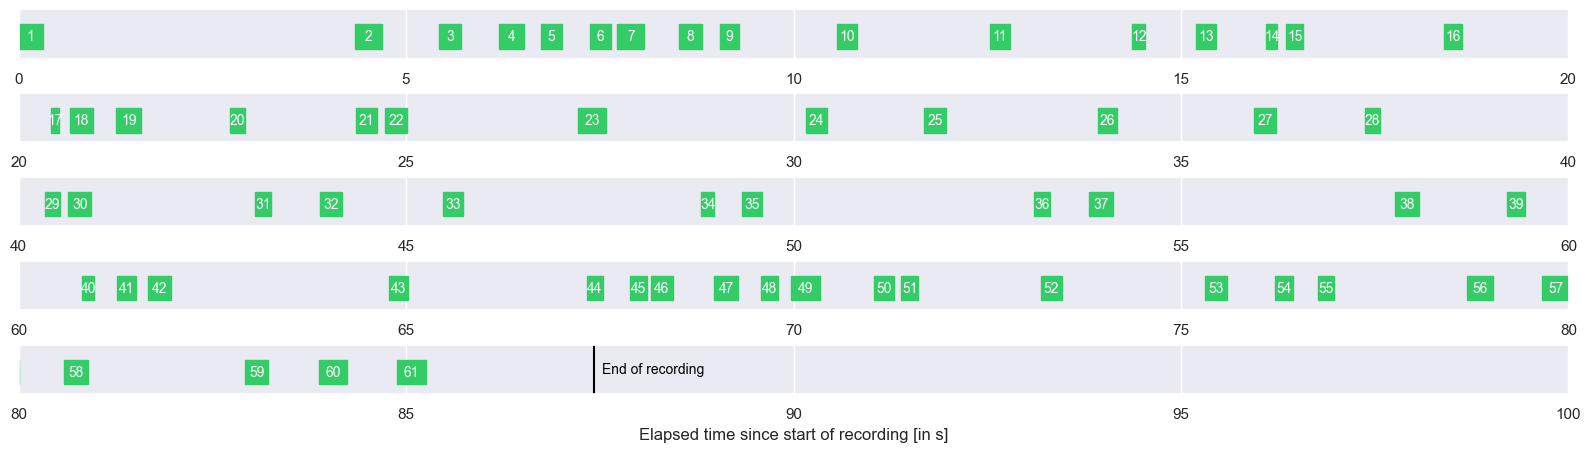

In [5]:
from blink_detector.helper import visualize_blink_events

# Limit the visualization to the first 200 s (if the recording is longer than that)
max_duration = 200

visualize_blink_events(blink_events, ts, max_duration)

Great, you have finished the first part of this tutorial! Next, we'll delve into using Pupil Lab's Realtime Python API to carry out blink detection in realtime.

# <font size=5> **Part 2:** Blink detection in real time using Pupil Lab's Realtime Python API</font>

As demonstrated in Part 1, applying the blink detection pipeline to pre-recorded data is quite easy. Moving forward, this next section of the tutorial will walk you through detecting eye blinks in near-realtime using Pupil Lab's Real Time API. Detecting eye blinks in realtime can be beneficial for tracking blink rate over time (potentially serving as a fatigue biomarker) or even leveraging specific blink patterns to control external devices. For instance, in the upcoming sections, we'll walk you through the process of remotely starting and stopping recordings with your Neon or Pupil Invisible device by executing a rapid sequence of three eye blinks.

Note that the temporal resolution of the blink detection is inherently limited by some of the (post-)processing parameters outlined in the [white paper](https://docs.google.com/document/d/1JLBhC7fmBr6BR59IT3cWgYyqiaM8HLpFxv5KImrN-qE/export?format=pdf). Moreover, the demands of the image processing can further impede performance. Consequently, there will be an inherent delay in blink detection, which makes it *near*-realtime rather than truly realtime.

# <font size=4>Dependencies</font>
In order to run this second part of the notebook, it is necessary to download and install *Pupil Lab's Realtime Python API*. You can find the code on GitHub (https://github.com/pupil-labs/realtime-python-api) and detailed instructions on how to install and use the realtime API in the documentation (https://pupil-labs-realtime-api.readthedocs.io). If you are running the code from a Jupyter notebook, you will also need to install `nest_asyncio`:

In [ ]:
pip install nest_asyncio

After you have successfully set up your environment, let’s first import all the required modules:

In [1]:
import nest_asyncio
import numpy as np
from pupil_labs.realtime_api.simple import discover_one_device
from blink_detector.blink_detector import blink_detection_pipeline
from blink_detector.helper import (
    stream_images_and_timestamps,
    update_array,
    compute_blink_rate,
    plot_blink_rate,
)

Next, we need to setup the real time API. We use Python's *asyncio* to implement asynchronous communication. In some environments, for example when working with Jupyter notebooks, asyncio won't work out of the box. We will make use of *nest_asyncio*, which allows *asyncio* to work also within Jupyter notebooks. 

In [2]:
nest_asyncio.apply()

In [3]:
# devices = discover_devices(20)
# device = next(d for d in devices if "tom" in d.phone_name.lower())
device = discover_one_device()

Printing the device name and its IP helps to make sure that the discovered device is indeed <br>
the device you would like to connect with.

In [4]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")

Phone IP address: 192.168.20.131
Phone name: Neon Companion Tom


Start and end Neon recording with 4 blinks in quick succession. Send event message to Neon with 3 blinks in quick succession.

In [6]:
import time
from collections import deque

device_is_recording = False

left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# initialize a deque with N zeros (N: number of successive blinks)
blink_queue = deque(maxlen=3)
blink_queue.extend(np.zeros(3))

# time interval within which the N blinks must occur
time_interval = 1.0

blink_event_stream = blink_detection_pipeline(left_images, right_images, timestamps)

while True:
    
    blink_event = next(blink_event_stream)

    blink_queue.append(blink_event.start_time / 1e9)

    toggle_recording = blink_queue[-1] - blink_queue[0] < time_interval

    if toggle_recording:
        if device_is_recording:
            if time.time() - start_of_recording < 0.5:
                print("Time between start and stop of recording is too short.")
                time.sleep(0.5)
            print("Stop recording")
            device.recording_cancel()
            device_is_recording = False
        else:
            print("Start recording")
            device.recording_start()
            device_is_recording = True
            start_of_recording = time.time()
            
        toggle_recording = False

Start recording
Stop recording
Start recording
Stop recording
Start recording
Stop recording
Start recording
Time between start and stop of recording is too short.
Stop recording
Start recording
Stop recording
Start recording
Time between start and stop of recording is too short.
Stop recording
Start recording
Stop recording
Start recording
Time between start and stop of recording is too short.
Stop recording
Start recording
Stop recording


KeyboardInterrupt: 

**Real-time blink rate since start of recording and over the last 30s**

In this last part of the Alpha Lab, we will show you how to utilize the Realtime API in combination with the blink detection pipeline in order to perform realtime blink-rate estimation.
**Limitation:** As the blink detection pipeline is a generator object, it will block execution of the code until a blink event is yielded. This means that any computation that is carried out within the for-loop will only execute once a blink occurs. This means that blink rate can only be updated once a blink is detected.

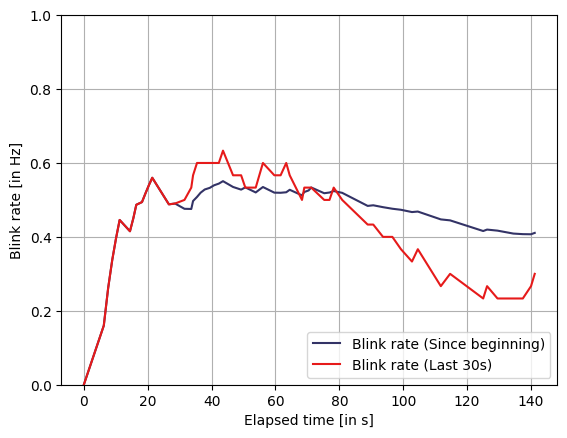

KeyboardInterrupt: 

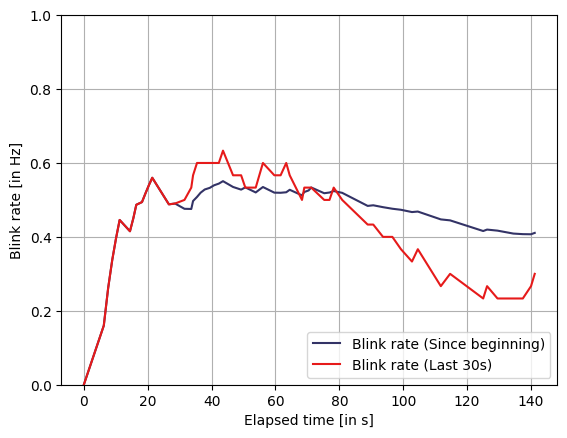

In [6]:
# we need to re-initialize the streams as the previous ones have been exhausted
left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

import time

# let's keep track of the last 100 blinks
blink_times = np.zeros(100)
blink_rate_tot = np.zeros(100)
blink_rate_30s = np.zeros(100)

blink_counter = 0
starting_time = time.time()

while True:

    blink_event = next(blink_detection_pipeline(left_images, right_images, timestamps))
    
    blink_counter += 1

    elapsed_time = blink_event.start_time / 1e9 - starting_time

    blink_times = update_array(blink_times, elapsed_time)

    blink_rate_tot = update_array(
        blink_rate_tot, compute_blink_rate(blink_counter, elapsed_time)
    )

    blink_counter_last_30s = np.sum(blink_times > max(blink_times[0] - 30, 0))

    blink_rate_30s = update_array(
        blink_rate_30s, blink_counter_last_30s / min(30, blink_times[0])
    )

    plot_blink_rate(blink_times, blink_rate_tot, blink_rate_30s)

In [6]:
np.random.rand(100)

array([0.10898318, 0.15145842, 0.96626416, 0.42192589, 0.93508653,
       0.10220343, 0.23227222, 0.70282935, 0.75614253, 0.01592504,
       0.16762118, 0.04775498, 0.0768265 , 0.8317128 , 0.25182611,
       0.40435241, 0.57203368, 0.16364371, 0.44356947, 0.53201788,
       0.75748976, 0.83847857, 0.82728579, 0.09291754, 0.60264581,
       0.2247896 , 0.06953263, 0.72907096, 0.47145755, 0.34811296,
       0.9888869 , 0.37251814, 0.35613722, 0.09173539, 0.00988954,
       0.4058961 , 0.17171649, 0.63323927, 0.10655188, 0.10855432,
       0.68437561, 0.92721175, 0.66234711, 0.27094707, 0.33370459,
       0.93852586, 0.64091051, 0.40841413, 0.71111729, 0.80783352,
       0.09911053, 0.21069638, 0.72142355, 0.54247601, 0.80951953,
       0.68763546, 0.62246905, 0.52724733, 0.86009566, 0.79179888,
       0.63646307, 0.59572558, 0.3799343 , 0.70554203, 0.77738703,
       0.57488447, 0.90382301, 0.58375905, 0.132601  , 0.78546401,
       0.72190902, 0.3449759 , 0.76882077, 0.84052989, 0.22471

In [13]:
import time
from threading import Event, Lock, Thread
from collections import deque
import numpy as np

frames = []
frames_lock = Lock()

left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# deque with 1 element
elapsed_time = deque(maxlen=100)
elapsed_time.extend(np.zeros(100))

# blink counter
# global blink_counter
blink_counter = 1
# deque(maxlen=1)
# blink_counter.extend(np.zeros(1))

# blink times
blink_times = deque(maxlen=100)
blink_times.extend(np.zeros(100))

blink_counter_last_30s = deque(maxlen=100)
blink_counter_last_30s.extend(np.zeros(100))

average_blink_rate = deque(maxlen=100)
average_blink_rate.extend(np.zeros(100))



def task1(done_event):

    starting_time = time.time()

    while True:

        elapsed_time.append(time.time() - starting_time)

        frames_lock.acquire()

        # calculate blink rate
        if elapsed_time[-1] > 0:
            
            average_blink_rate.append(blink_counter / elapsed_time[-1])

        
           # print blink rate to same line
            print(f"\rBlink rate: {average_blink_rate[-1]:.2f}", end="")

        # blink rate over last 30s
        # blink_counter_last_30s.append(np.sum(np.array(blink_times) > max(blink_times[-1] - 30, 0)) / 30)
        # print(f"\rBlink rate (last 30s): {blink_counter_last_30s[-1]:.2f}", end="")

        # plot_blink_rate(np.array(elapsed_time), 
        #                 np.array(average_blink_rate), 
        #                 # np.random.rand(100)
        # )

        # time.sleep(0.5)
        

        # try:
        #     print(f"{start_time[-1]:.2f}")
        # except:
        #     print("No blink yet")
        frames_lock.release()
        if done_event.wait(0.001):
            break

def task2(done_event):
    
   # blink_counter = 0

    while True:
        
        blink_event = next(blink_detection_pipeline(left_images, right_images, timestamps))

        if elapsed_time[-1] > 0:
            
            frames_lock.acquire()

            blink_counter = blink_counter + 1
            # blink_counter.append(blink_counter[-1] + 1)

            blink_times.append(blink_event.start_time / 1e9)

            frames_lock.release()
        
        if done_event.wait(0.001):
            break

def main():

    try:

        done_event = Event()

        t1 = Thread(target=task1, args=(done_event,))
        t2 = Thread(target=task2, args=(done_event,))

        t1.start()
        t2.start()

        time.sleep(20)
    
    except KeyboardInterrupt:
    
        print("KeyboardInterrupt")
    
    finally:
    
        done_event.set()

        t1.join()
        t2.join()

main()

Blink rate: 0.1429

Exception in thread Thread-21 (task2):
Traceback (most recent call last):
  File "/Users/tpfeffer/opt/anaconda3/envs/py310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/tpfeffer/opt/anaconda3/envs/py310/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/6s/7t24f5ts6d51jy_w7578ts2h0000gn/T/ipykernel_12288/2050424867.py", line 85, in task2
UnboundLocalError: local variable 'blink_counter' referenced before assignment


Blink rate: 0.13

**(2.4) Run blink detection pipeline**

In [17]:
# blink times
blink_times = deque(maxlen=100)
blink_times.extend(np.random.rand(100))

In [22]:
max(blink_times)

0.9872150914058786

In [31]:
average_blink_rate = deque(maxlen=100)
average_blink_rate.extend(np.zeros(100))

average_blink_rate.append(1)

In [32]:
average_blink_rate[-1]

1

KeyboardInterrupt: 

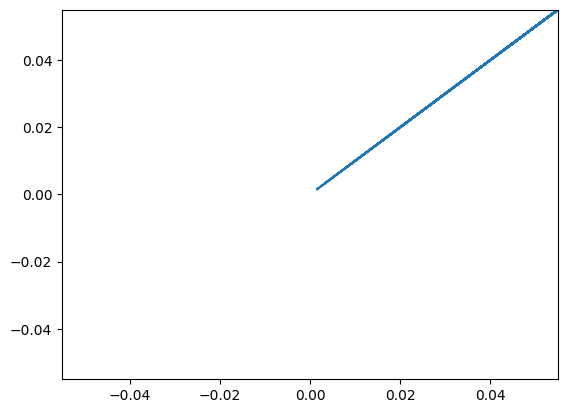

In [10]:
import matplotlib.pyplot as plt
import numpy as np

hl, = plt.plot([], [])

def update_line(hl, new_data):
    hl.set_xdata(np.append(hl.get_xdata(), new_data))
    hl.set_ydata(np.append(hl.get_ydata(), new_data))
    plt.draw()


while True:
    new_data = np.random.rand(1)
    update_line(hl, new_data)


<IPython.core.display.Javascript object>

KeyboardInterrupt: 